In [1]:
import torch
import itertools
import pandas as pd
import seaborn as sns
import torchmetrics as tm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from argo.datasets.sepsis import get_clinician_dataset, get_judge_dataset, SEPSIS_FEATURES_DEMOGRAPHIC, SEPSIS_FEATURES_OBSERVATIONAL

In [3]:
COLUMNS = SEPSIS_FEATURES_OBSERVATIONAL + SEPSIS_FEATURES_DEMOGRAPHIC

In [4]:
_ = sns.set_theme(
    style="white", context="paper",
    palette="muted",
    rc={
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "font.size": 25,
        "axes.titlesize": 25,
        "axes.labelsize": 25,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "legend.columnspacing": 1,
        "legend.title_fontsize": 20,
        "figure.figsize": (6.4, 6.4),
    },
)

# Analysis of Sepsis dataset

The first section of this notebook focuses on analysis of the pure sepsis dataset, obtained as the output of `scripts.data.generate` function.

## Exploratory Data Analysis

First, we perform some exploratory analysis over the training set.

In [6]:
data = torch.load("./assets/data/sepsis/train_dict.pt")
dataset, dataloader, _ = get_clinician_dataset(data_dict=data, batch_size=64, use_dem=True, weighted_sampling=False, perform_scaling=False)

In [7]:
X, Y = dataset[:][0], dataset[:][1]
df = pd.DataFrame(torch.cat((X, Y.reshape(-1, 1)), dim=1).numpy(), columns=COLUMNS + ["o:action"])
df["o:action"] = df["o:action"].astype(int)
df.head()

,o:SOFA,o:SIRS,o:Shock_Index,o:output_4hourly,o:output_total,o:cumulated_balance,o:GCS,o:HR,o:SysBP,o:MeanBP,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:gender,o:mechvent,o:age,o:Weight_kg,o:action
0,-0.5,-0.5,-0.969956,-0.180087,-0.766305,-0.595638,-0.129925,0.678752,0.778366,-0.732976,...,-0.581899,0.198678,-0.079185,-0.474941,0.365631,0.162389,-0.493392,-0.204572,0.772373,10
1,-0.5,-0.5,-0.969956,-0.180087,-0.183319,0.355569,-0.418255,0.570550,0.786210,-0.759312,...,-0.639494,0.560011,-1.002711,-0.661475,-0.174112,-0.179201,1.706064,-0.954174,0.777506,10
2,-0.5,-0.5,-0.969956,-0.180087,-0.183319,0.355569,-0.555245,0.489509,0.792089,-0.778542,...,-0.639494,0.347419,-1.002711,-0.661475,-0.174112,-0.179201,1.706064,-0.954174,0.782601,10
3,-0.5,-0.5,-0.969956,-0.147372,0.108175,-0.595638,-0.384696,0.548860,0.799075,-0.802788,...,-0.743165,0.106864,-1.002711,-0.661475,-0.174112,-0.179201,1.706064,-0.204572,0.787657,10
4,-0.5,-0.5,-0.969956,-0.139194,-0.766305,0.355569,-0.332081,0.690291,0.809843,-0.843756,...,1.368515,0.106864,-1.002711,-0.661475,-0.174112,-0.179201,1.706064,-0.204572,0.792676,10


In [8]:
df.describe()

,o:SOFA,o:SIRS,o:Shock_Index,o:output_4hourly,o:output_total,o:cumulated_balance,o:GCS,o:HR,o:SysBP,o:MeanBP,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:gender,o:mechvent,o:age,o:Weight_kg,o:action
count,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,...,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000,172826.000000
mean,-0.062358,-0.141321,-0.003355,0.002674,-0.001603,-0.000106,-0.002496,0.002693,0.000449,-0.001923,...,0.000519,-0.000597,0.003139,0.004600,0.003106,0.003862,-0.002601,0.005570,-0.001009,9.312169
std,0.496098,0.479614,1.004403,1.006154,0.995898,1.000296,0.998495,0.998243,0.997069,0.988601,...,1.004263,0.984521,1.000172,0.999631,1.001960,1.000153,0.996018,1.003651,2.002574,7.638957
min,-0.500000,-0.500000,-2.784804,-3.398358,-1.640785,-1.546845,-3.929830,-1.937739,-2.727011,-27.555826,...,-1.141752,-20.749304,-4.326332,-3.954695,-5.995981,-5.283453,-2.302361,-8.407532,-6.685323,0.000000
25%,-0.500000,-0.500000,-0.664502,-0.674891,-0.766305,-0.595638,-0.718726,0.065927,-0.073410,-0.229930,...,-0.674463,-0.553625,-0.658751,-0.661475,-0.707666,-0.684918,-0.677465,-0.683717,-0.178801,0.000000
50%,-0.500000,-0.500000,0.080038,-0.147372,-0.183319,0.355569,-0.105400,0.415795,0.261178,-0.052408,...,-0.381560,0.126967,-0.079185,-0.157139,-0.200168,-0.179201,-0.202947,-0.204572,0.565847,10.000000
75%,0.500000,0.500000,0.793525,0.502825,0.691161,0.355569,0.602604,0.627680,0.543228,0.255437,...,0.366361,0.758272,0.692931,0.436265,0.437066,0.453999,0.496858,0.210483,1.045776,15.000000
max,0.500000,0.500000,1.614106,8.665047,4.772066,2.257983,4.366068,1.588812,1.723724,31.198389,...,5.779999,1.217013,3.597068,7.530412,5.276683,4.998003,4.390676,8.045604,3.527046,24.000000


## Action Analysis

In this section, we analyse the available actions (medications) prescribed by the clinicians.

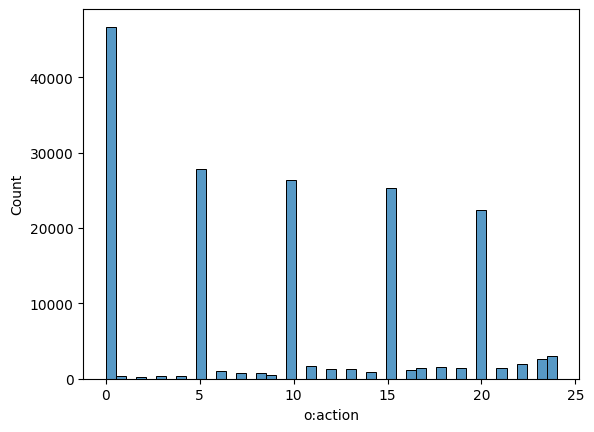

In [34]:
fig, ax = plt.subplots(1)
_ = sns.histplot(data=df, x="o:action", ax=ax)

Next, we calculate the median value of each medication choice (IV/VC). These values are also used when calculating the dose excess (see also `eval_protagonist.ipynb`).

In [35]:
data_raw = pd.read_csv("./assets/data/sepsis/sepsis_final_data_raw.csv")
act_median_map = {i: {"iv": 0.0, "vc": 0.0} for i in range(5 * 5)}

In [36]:
for act_ind in range(5 * 5):
    iv_ind, vc_ind = act_ind // 5, act_ind % 5
    iv_acts = [iv_ind * 5 + i for i in range(5)]
    vc_acts = [vc_ind + 5 for _ in range(5)]
    act_median_map[act_ind] = {
        "iv": data_raw[data_raw["a:action"].isin(iv_acts)]["o:input_4hourly"].median(),
        "vc": data_raw[data_raw["a:action"].isin(vc_acts)]["o:max_dose_vaso"].median(),
    }

In [37]:
pd.DataFrame(act_median_map)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
iv,0.0,0.000,0.0000,0.000,0.000,30.0,30.000,30.0000,30.000,30.000,...,290.0,290.000,290.0000,290.000,290.000,856.0,856.000,856.0000,856.000,856.000
vc,0.0,0.036,0.1195,0.225,0.675,0.0,0.036,0.1195,0.225,0.675,...,0.0,0.036,0.1195,0.225,0.675,0.0,0.036,0.1195,0.225,0.675


## Preference Dataset

In this section, we examine the used preference dataset.

In [29]:
preferences = torch.load("./assets/data/sepsis/train_preferences.pt", map_location="cpu")
a1 = preferences[:][1].tolist()
a2 = preferences[:][2].tolist()
pref = preferences[:][3].tolist()

In [50]:
counts = {i: {j: 0 for j in range(5 * 5)} for i in range(5 * 5)}
for a, b, p in zip(a1, a2, pref):
    a_t = a if p[0] == 1.0 else b
    a_r = a if p[0] == 0.0 else b
    counts[a_t][a_r] += 1
counts = pd.DataFrame(counts)

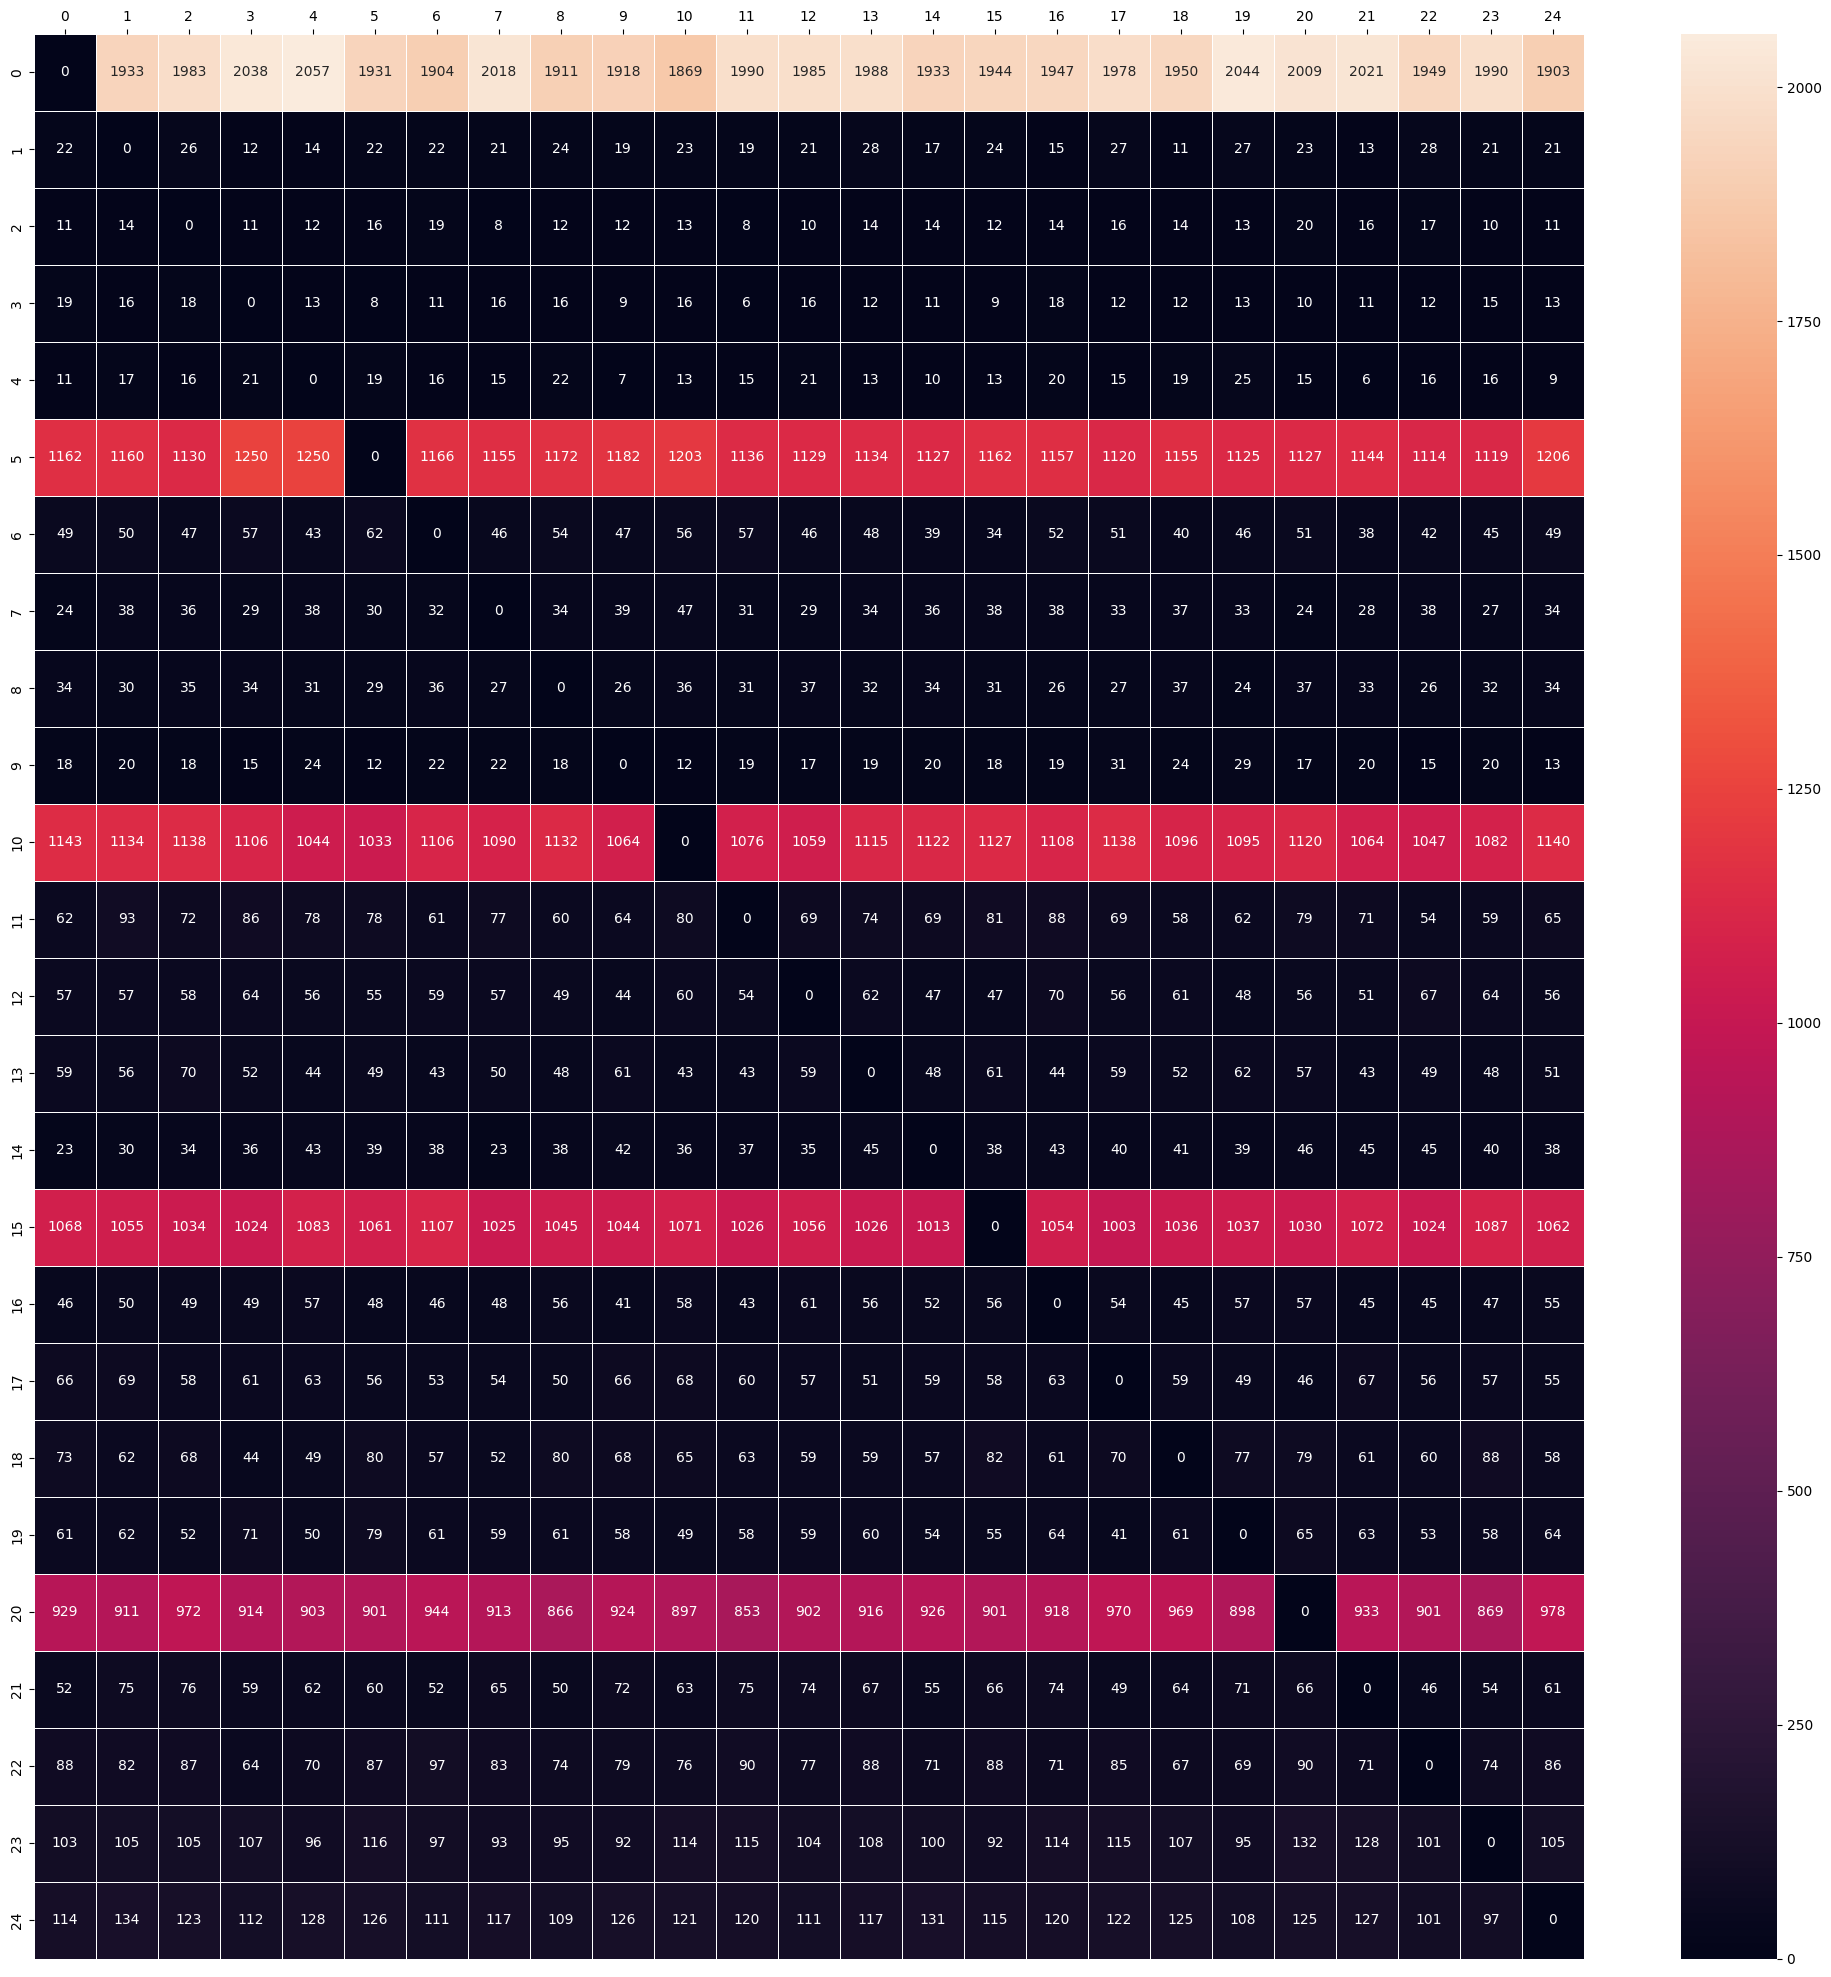

In [73]:
fig, ax = plt.subplots(1, figsize=(25, 25))
_ = sns.heatmap(data=counts.T, annot=True, linewidth=0.5, fmt="g", ax=ax)
_ = ax.xaxis.tick_top()

### Synthetic Dataset Variations

We examine some alternative when it comes to creating a synthetic dataset of preferences.

In [5]:
device = "cpu"
judge_random_metrics = "./assets/data/sepsis/rebuttal/judge_method_random/metrics.pt"
judge_offset_metrics = "./assets/data/sepsis/rebuttal/judge_method_offset/metrics.pt"
judge_exhaustive_metrics = "./assets/data/sepsis/rebuttal/judge_method_exhaustive/metrics.pt"

In [8]:
data = pd.DataFrame([
    {"method": "random", "accuracy": torch.load(judge_random_metrics)["test"]["test_accuracy"].item()},
    {"method": "offset", "accuracy": torch.load(judge_offset_metrics)["test"]["test_accuracy"].item()},
    {"method": "exhaustive", "accuracy": torch.load(judge_exhaustive_metrics)["test"]["test_accuracy"].item()},
])
data.method = pd.Categorical(data.method, ["offset", "random", "exhaustive"])

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)


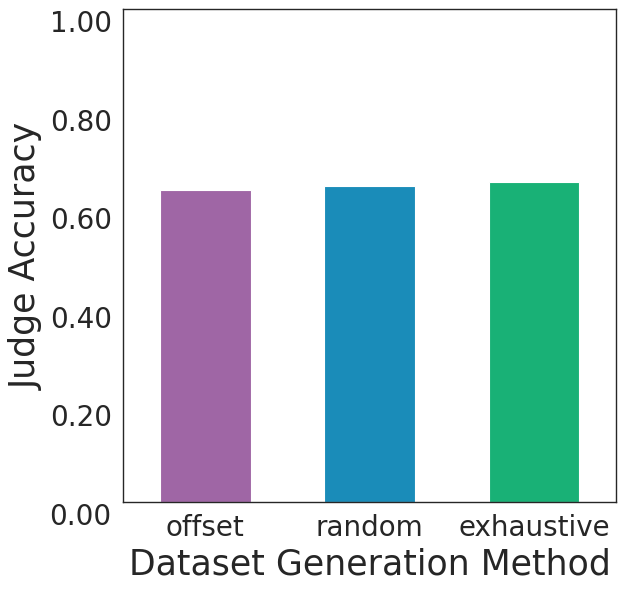

In [26]:
fig, ax = plt.subplots(1)

ax = sns.barplot(data=data, x="method", y="accuracy", alpha=1.0, ax=ax, hue="method", width=0.55, palette={"offset": "#a85bb0", "random": "#0098d3", "exhaustive": "#00ca7c"})
_ = ax.set_xlabel("Dataset Generation Method")
_ = ax.set_ylabel("Judge Accuracy")
_ = ax.set_ylim([0.0, 1.0])
_ = ax.set_box_aspect(1)
_ = [a.set_va("top") for a in ax.get_yticklabels()]
_ = ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.2f"))

fig.savefig("./results/plots/judge__dataset_generation_method.pdf", bbox_inches="tight")